<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/gans_for_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font size="30">Generating Tabular Data using GANs</font></center></h1>

# Generative Adversarial Networks

Generative Adversarial Networks are type of unsupervised machine learning method which try to generate new, synthetic instances of data that mimics the real data. They are extremely popular in image, video (Deepfake) and voice generation. Generating tabular data using GANs isn't as popular as generating images, but can still produce some pretty good results. This notebook tries to do just that. GANs are constructed of two neural networks: Generator and Discriminator. Generator, using some random noise as input, tries to mimic the real data and Discriminator tries to classify the data into real and fake. It could be said that they are eachothers enemies. Both Neural Networks (Generator and Discriminator) are trained separately through backpropagation with regards to their loss.

## Conditional GAN

Conditional GAN or cGAN is a type of Generative Adversarial Network which adds the label y as an additional parameter to the generator in hope that the corresponding data will be generated. The labels are also added to the discriminator input to distinguish real data better.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [ ]:
class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=32, out_shape=14):

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        # See https://stackoverflow.com/q/55052547/3282777
        #  Embedding(voc, vector)
        # https://livebook.manning.com/book/gans-in-action/chapter-8/79
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

# Adult Census Income Dataset

First dataset has 15 features including one class that we will try to predict (income). Dataset contains a lot of categorical features that need some preprocessing before feeding it into the algorithm.

In [ ]:
df = pd.read_csv('../input/adult-census-income/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Before employing any algorithms, we will first preprocess some data.

## Preprocessing

Since the goal of this notebook is to examine how good the generated synthetic data is, we won't analyse and do any feature engineering. It is also not that important that we get the best possible result with the algorithm, so that's one of the reasons why we will only use label-encoding (on some features normally one-hot encoding should be a better approach).

In [ ]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital.status','occupation','relationship','race','sex','native.country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


In [ ]:
df.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

### Splitting the dataframe

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('income', 1))
y = df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Classifying using real trainset

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4901
           1       0.78      0.65      0.71      1612

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513



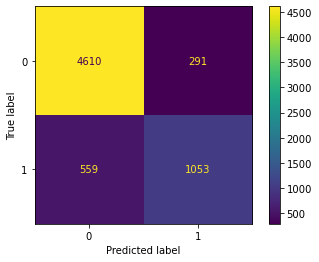

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

### Training cGAN

In [ ]:
cgan = cGAN()

[99/500]	Loss_D: 0.6904	Loss_G: 0.6678
[199/500]	Loss_D: 0.6802	Loss_G: 0.6891
[299/500]	Loss_D: 0.6642	Loss_G: 0.7140
[399/500]	Loss_D: 0.5067	Loss_G: 1.1763
[499/500]	Loss_D: 0.4999	Loss_G: 1.3333


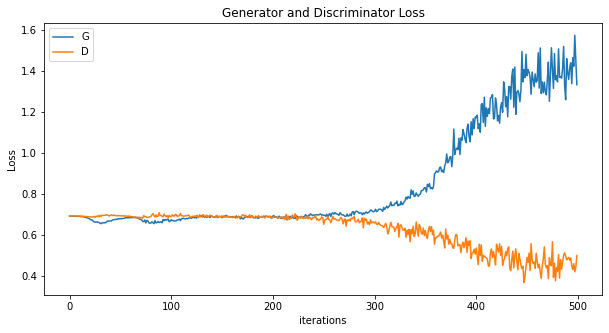

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

### Generating new instances

In [ ]:
# we want to generate 19758 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (19758, 32))
sampled_labels = np.zeros(19758).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('income',1).columns)

In [ ]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (6290, 32))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('income',1).columns)

### Combining generated instances into a dataframe

In [ ]:
gen_df_2['income'] = 1
gen_df['income']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('income', 1)
y_train_2 = df_gan['income'].values

### Classifying testset using generated trainset

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      4901
           1       0.51      0.09      0.16      1612

    accuracy                           0.75      6513
   macro avg       0.64      0.53      0.51      6513
weighted avg       0.70      0.75      0.68      6513



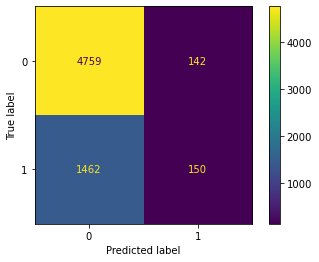

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

# Skin Segmentation Dataset

Skin segmentation dataset has 3 features (B, G, R) and one class (skin-nonskin). The dataset is extracted from images of peoples faces, so that each row presents a pixel and each pixel represents how much of that color is attained in it (i.e. B represents how much blue does a pixel have). Class tells us if the given row (pixel) is a skin or not. People represented in the images vary in age, race and gender.

In [ ]:
df2 = pd.read_csv('../input/ucuss/Skin_NonSkin.txt', sep='\t', header=None, names=['B','G','R','Class'])
df2.Class = df2.Class.replace([1, 2], [0, 1])
df2.head()

,B,G,R,Class
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [ ]:
df2.Class.value_counts()

1    194198
0     50859
Name: Class, dtype: int64

### Splitting the Dataframe

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(df2.drop('Class', 1))
y = df2['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Classifying using real trainset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10159
           1       1.00      1.00      1.00     38853

    accuracy                           1.00     49012
   macro avg       1.00      1.00      1.00     49012
weighted avg       1.00      1.00      1.00     49012



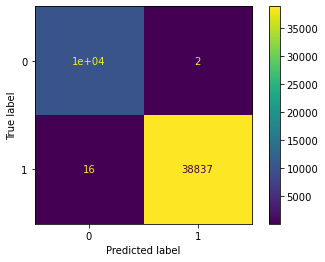

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)


y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

### Training cGAN

In [ ]:
cgan = cGAN(out_shape=3)

[99/100]	Loss_D: 0.6894	Loss_G: 0.6928


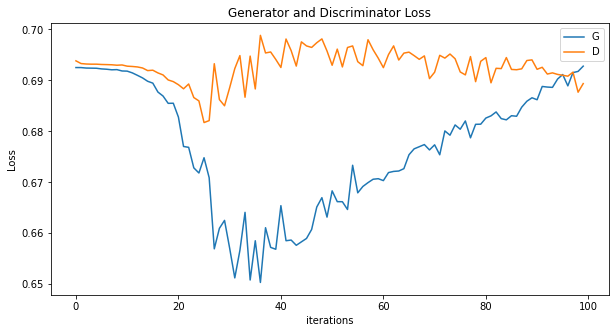

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train,pos_index, neg_index, epochs=100)

### Generating new instances

In [ ]:
# we want to generate 40572 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (40572, 32))
sampled_labels = np.zeros(40572).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df2.drop('Class',1).columns)
gen_df.head()

,B,G,R
0,0.882154,-0.666110,0.999997
1,-0.969396,-0.766087,0.999812
2,0.763742,0.589939,0.999967
3,-0.366930,-0.690233,0.999951
4,-0.025381,-0.519304,0.999886


In [ ]:
# we want to generate 155473 instances with class value 1 since that represents how many 1s are in the real training set
noise_2 = np.random.normal(0, 1, (155473, 32))
sampled_labels_2 = np.ones(155473).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df2.drop('Class',1).columns)
gen_df_2.head()

,B,G,R
0,0.940194,-0.268367,-0.999996
1,-1.000000,-1.000000,-1.000000
2,0.991539,0.884005,-0.466823
3,-1.000000,-1.000000,-0.999969
4,-0.946706,-0.730447,-1.000000


### Combining generated instances into a dataframe

In [ ]:
gen_df_2['Class'] = 1
gen_df['Class']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('Class', 1)
y_train_2 = df_gan['Class'].values

### Classifying testset using generated trainset

              precision    recall  f1-score   support

           0       0.70      0.82      0.76     10159
           1       0.95      0.91      0.93     38853

    accuracy                           0.89     49012
   macro avg       0.83      0.87      0.84     49012
weighted avg       0.90      0.89      0.89     49012



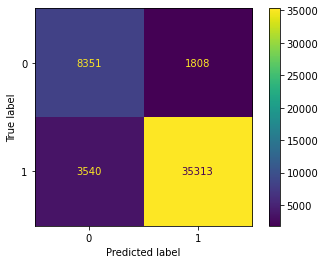

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

## EXPERIMENTS

In [ ]:
def generate_instances(df_new, cgan,num_instances,label_class,label='income'):
    noise = np.random.normal(0, 1, (num_instances, 32))

    if label_class==0:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])
    else:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])

    gen_df = pd.DataFrame(data = gen_samples,
                          columns = df_new.drop(label,1).columns)
    return gen_df


In [ ]:
def run_experiment(df_new, pos_num_inst, neg_num_inst, num_epochs, out_sh, latent_d=32, label_f='income'):

    global bal_acc, acc, G_loss, D_loss
    G_loss = []
    D_loss = []
    bal_acc = []
    acc = []

    X = scaler.fit_transform(df_new.drop(label_f, 1))
    y = df_new[label_f].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    cgan=cGAN(latent_dim=latent_d, out_shape=out_sh)
    y_train = y_train.reshape(-1,1)
    pos_index = np.where(y_train==1)[0]
    neg_index = np.where(y_train==0)[0]

    for i in range(5):
        print(str(i+1)+". RUN")

        cgan.train(X_train, y_train, pos_index, neg_index, epochs=num_epochs, plot=False)
        gen_df = generate_instances(df_new, cgan=cgan,num_instances=pos_num_inst, label_class=1, label=label_f)
        gen_df_2 = generate_instances(df_new,cgan=cgan, num_instances=neg_num_inst, label_class=0, label=label_f)

        gen_df[label_f] = 1
        gen_df_2[label_f] = 0

        df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
        df_gan = df_gan.sample(frac=1).reset_index(drop=True)

        X_train_2 = df_gan.drop(label_f, 1)
        y_train_2 = df_gan[label_f].values

        lgb_1 = lgb.LGBMClassifier()
        lgb_1.fit(X_train_2, y_train_2)

        y_pred = lgb_1.predict(X_test)

        G_loss.append(G_losses)
        D_loss.append(D_losses)

        bal_acc.append(balanced_accuracy_score(y_test, y_pred))
        acc.append(accuracy_score(y_test, y_pred))

        print("Bal_Acc:", bal_acc[i])
        print("Acc:", acc[i])

    Sum_G_loss = [sum(x) for x in zip(*G_loss)]
    Sum_D_loss = [sum(x) for x in zip(*D_loss)]
    Avg_G_loss = [x / 5 for x in Sum_G_loss]
    Avg_D_loss = [x / 5 for x in Sum_D_loss]

    plt.figure(figsize=(10,5))
    plt.title("Average Generator and Discriminator Loss")
    plt.plot(Avg_G_loss,label="G")
    plt.plot(Avg_D_loss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

1. RUN
[99/2000]	Loss_D: 0.6939	Loss_G: 0.6688
[199/2000]	Loss_D: 0.6835	Loss_G: 0.7381
[299/2000]	Loss_D: 0.0652	Loss_G: 3.1275
[399/2000]	Loss_D: -0.1123	Loss_G: 8.9667
[499/2000]	Loss_D: -0.5655	Loss_G: 16.7729
[599/2000]	Loss_D: -1.0054	Loss_G: 29.9625
[699/2000]	Loss_D: -1.3712	Loss_G: 47.1288
[799/2000]	Loss_D: -1.7645	Loss_G: 69.8977
[899/2000]	Loss_D: -3.9128	Loss_G: 91.8820
[999/2000]	Loss_D: -6.1514	Loss_G: 138.6288
[1099/2000]	Loss_D: -15.9926	Loss_G: 168.4970
[1199/2000]	Loss_D: -10.8175	Loss_G: 126.0121
[1299/2000]	Loss_D: -27.0119	Loss_G: 185.8862
[1399/2000]	Loss_D: 1.1891	Loss_G: 200.2897
[1499/2000]	Loss_D: 10.6957	Loss_G: 193.8070
[1599/2000]	Loss_D: 0.1213	Loss_G: 175.5405
[1699/2000]	Loss_D: 0.0038	Loss_G: 196.0031
[1799/2000]	Loss_D: 0.1031	Loss_G: 144.6655
[1899/2000]	Loss_D: 0.0872	Loss_G: 145.8593
[1999/2000]	Loss_D: 0.0381	Loss_G: 108.4187
Bal_Acc: 0.5017306014665315
Acc: 0.764163979732842
2. RUN
[99/2000]	Loss_D: -55.8872	Loss_G: 92.5559
[199/2000]	Loss_D: -53

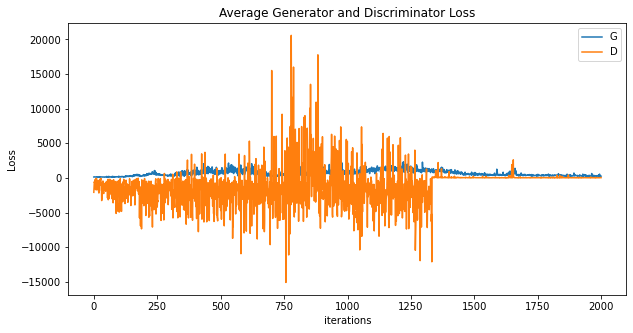

CPU times: user 13min 44s, sys: 54.9 s, total: 14min 39s
Wall time: 11min 41s


In [ ]:
%%time
run_experiment(df_new=df, pos_num_inst=6290, neg_num_inst=19758, num_epochs=2000, out_sh=14)

1. RUN
[99/2000]	Loss_D: 0.6810	Loss_G: 0.6968
[199/2000]	Loss_D: 0.5385	Loss_G: 0.7607
[299/2000]	Loss_D: 0.6256	Loss_G: 0.9017
[399/2000]	Loss_D: 0.4338	Loss_G: 0.9667
[499/2000]	Loss_D: 0.5547	Loss_G: 1.1081
[599/2000]	Loss_D: 0.3890	Loss_G: 1.1673
[699/2000]	Loss_D: 0.3667	Loss_G: 0.9513
[799/2000]	Loss_D: -0.9167	Loss_G: 1.6648
[899/2000]	Loss_D: -0.4546	Loss_G: 1.6291
[999/2000]	Loss_D: -3.1474	Loss_G: 1.4564
[1099/2000]	Loss_D: -7.2732	Loss_G: 2.8160
[1199/2000]	Loss_D: -5.2339	Loss_G: 1.7202
[1299/2000]	Loss_D: -1.1398	Loss_G: 3.2881
[1399/2000]	Loss_D: 0.7417	Loss_G: 1.9758
[1499/2000]	Loss_D: 0.9862	Loss_G: 2.2168
[1599/2000]	Loss_D: 1.0215	Loss_G: 2.4925
[1699/2000]	Loss_D: 0.5577	Loss_G: 2.6706
[1799/2000]	Loss_D: 0.5733	Loss_G: 2.9378
[1899/2000]	Loss_D: 0.6743	Loss_G: 2.7238
[1999/2000]	Loss_D: 0.4983	Loss_G: 2.5313
Bal_Acc: 0.4964663029370069
Acc: 0.7866644903288991
2. RUN
[99/2000]	Loss_D: -20.8813	Loss_G: 3.7900
[199/2000]	Loss_D: -10.6998	Loss_G: 6.1152
[299/2000]	Los

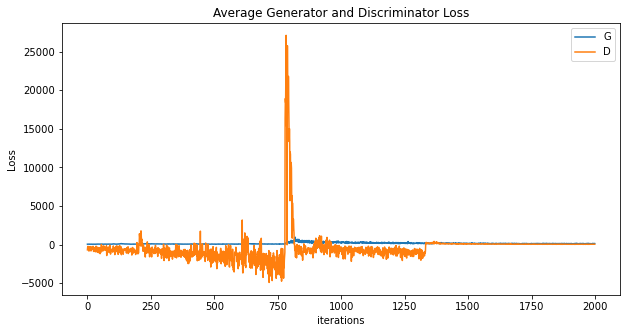

CPU times: user 14min 59s, sys: 59 s, total: 15min 57s
Wall time: 12min 30s


In [ ]:
%%time
run_experiment(df_new=df2, pos_num_inst=155289, neg_num_inst=40756, num_epochs=2000, out_sh=3,label_f='Class')